In [6]:
!pip install shap
!pip install optuna

from __future__ import print_function, division   # Ensures Python3 printing & division standard
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# ML
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import lightgbm as lgb
import shap # shap values
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

# hyperparameter search
import optuna

# random seed
np.random.seed(42)

In [7]:
# ===============================
# define function for evaluation
# ===============================

def evaluate_regression(xgb_reg, X_train, y_train, y_test, y_pred, k=5):
    # input: xgb_reg = XGBoost regression
    # input: X_train = data training
    # input: y_train = target training
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test
    # input: y_pred = is the y values (here energy) predicted for the X_test
    # checked on 19/05/2024
    
    # Evaluate the model using mean absolute error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error: {mae}")
    
    # Evaluate the model using mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"Mean Squared Error: {mse}")
    print(f"Root Mean Squared Error: {rmse}")
    
    # Evaluate the model using R-squared (R2) score
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared Score: {r2}")
    
    # Evaluate the model using median absolute error
    medae = median_absolute_error(y_test, y_pred)
    print(f"Median Absolute Error: {medae}")

    # Compute the Mean Absolute Error on relative estimate accuracy: (E_pred-E_true)/E_true
    relative_errors = np.abs((y_pred - y_test) / y_test)
    mae_relative = np.mean(relative_errors)
    print(f"Mean Absolute Error on Relative Estimate Accuracy: {mae_relative}")

    # Perform k-fold cross-validation (e.g., k=5)
    cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=k, scoring='neg_mean_absolute_error')
    print("Cross-Validation: %.4f +- %.4f" %(-cv_scores.mean(), cv_scores.std()))

def test_overfitting(estimator, score_func, X_train, y_train, X_test, y_test, X_valid, y_valid, prob=False):
    # input: score_func = function, like mean_absolute_error for regression
    # input: prob = bool, to use either probability prediction or number/discrete prediction for score function
    # checked 19/05/2024

    if prob:
        y_pred_train = estimator.predict_proba(X_train)
        y_pred_test = estimator.predict_proba(X_test)
        y_pred_valid = estimator.predict_proba(X_valid)
    else:        
        y_pred_train = estimator.predict(X_train)
        y_pred_test = estimator.predict(X_test)
        y_pred_valid = estimator.predict(X_valid)
    
    accuracy_train = score_func(y_train, y_pred_train)
    accuracy_test = score_func(y_test, y_pred_test)
    accuracy_valid = score_func(y_valid, y_pred_valid)
    
    print(f"Training Accuracy: {accuracy_train:.4f}")
    print(f"Test Accuracy: {accuracy_test:.4f}")
    print(f"Valid Accuracy: {accuracy_valid:.4f}")

    # if I want to plot evolution of training and validation metrics I can either use in build function like in tensorflow or create a list
    # of training scores and validation scores depending on n_estimators/epochs --- but this need computational power --- probably

def evaluation_plot(estimator, y_test, y_pred):
    # input: estimator = xgb_cl - XGBClassifier with all the hyperparameter, for example
    # input: y_test = we divided our y (labeled feature we want to know) into train, test, validation, y_test is the part from test 
    # input: y_pred = is the y values predicted for the X_test
    # plot the figures from the feedback document of the inital project in applied machine learning 2024 
    # (Diversion, Distribution Residuals and Relative Errors)
    # checked 04/06/2024

    y_test = np.array(y_test) 
    residuals = y_test - y_pred
    relative_errors = residuals / np.abs(y_test)
    relative_errors = relative_errors[np.abs(relative_errors) <= 1.5]
    percentile_90 = np.percentile(np.abs(residuals), 90)
    high_residual_mask = np.abs(residuals) <= percentile_90

    # Plot the Distribution of the Residuals and the Relative Errors
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(residuals, bins=100)
    ax1.set_title('Distribution of Residuals')
    ax1.set_xlabel('Residuals')
    ax1.set_ylabel('Count')
    #ax1.set_xlim()
    
    ax2.hist(relative_errors, bins=100)
    ax2.set_title('Distribution of Relative Errors')
    ax2.set_xlabel('Relative Prediction Error')
    ax2.set_ylabel('Count')
    ax2.set_xlim(-1.5, 1.5)
    plt.tight_layout()
    plt.show()
    
    # Plot the Diversion
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, c='blue', alpha=0.1, label='100th percentile')
    plt.scatter(y_test[high_residual_mask], y_pred[high_residual_mask], c='green', alpha=0.1, label='residual <= 90th percentile')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='orange', linewidth=2)
    plt.xlabel('Label [m]')
    plt.ylabel('Prediction [m]')
    plt.title('Thickness Diversion')
    plt.legend()
    plt.savefig('Diversion_Niccolo.png', dpi=300, bbox_inches='tight', format='png')
    plt.show()
    
    # Plot the RMSE for training and validation sets
    results = estimator.evals_result()
    epochs = len(results['validation_0']['mae'])
    x_axis = range(0, epochs)

    # Plot RMSE and MAE metric
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.plot(x_axis, results['validation_0']['rmse'], label='Train')
    ax1.plot(x_axis, results['validation_1']['rmse'], label='Test')
    ax1.plot(x_axis, results['validation_2']['rmse'], label='Validation')
    ax1.legend(loc='upper right')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('RMSE')
    ax1.set_title('Evolution of the Root Mean Squared Error')

    ax2.plot(x_axis, results['validation_0']['mae'], label='Train')
    ax2.plot(x_axis, results['validation_1']['mae'], label='Test')
    ax2.plot(x_axis, results['validation_2']['mae'], label='Validation')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Evolution of the Mean Absolute Error')
    plt.tight_layout()
    plt.show()
    
    

In [8]:
class CFG:
    min_thick_value_train = 1.0

    featuresSmall = ['RGI', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope', 'Lmax', 'Form', 'TermType', 'Aspect',
                     'elevation', 'elevation_from_zmin', 'dist_from_border_km_geom',
                     'slope50', 'slope100', 'slope150', 'slope300', 'slope450', 'slopegfa',
                     'curv_50', 'curv_300', 'curv_gfa', 'aspect_50', 'aspect_300', 'aspect_gfa', 'lat', 'dmdtda_hugo',
                     'smb']

    features_train = featuresSmall + ['vx_gfa', 'vy_gfa', 'v50', 'v100', 'v150', 'v300', 'v450', 'vgfa']
    target = 'THICKNESS'
    millan = 'ith_m'
    farinotti = 'ith_f'
    model = lgb.LGBMRegressor()

In [9]:
# load the dataset
path = r'data/'
metadata_file = "metadata19_hmineq0.0_tmin20050000_mean_grid_20.csv"
glathida_rgis = pd.read_csv(path + metadata_file, low_memory=False)

In [10]:
# check for nan values and for shape if it uploaded correctly on erda
columns_with_nan = glathida_rgis.columns[glathida_rgis.isna().any()].tolist()
print("Columns with NaN values in data_deep_thick:", columns_with_nan)
print("The shape is ", glathida_rgis.shape)

Columns with NaN values in data_deep_thick: ['ith_m', 'ith_f']
The shape is  (81290, 58)


In [11]:
# pre-processing
glathida_rgis = glathida_rgis.dropna()
glathida_rgis = glathida_rgis.loc[glathida_rgis['THICKNESS']>=CFG.min_thick_value_train]

# add some features for training
glathida_rgis['lat'] = glathida_rgis['POINT_LAT']
glathida_rgis['v50'] = np.sqrt(glathida_rgis['vx_gf50']**2 + glathida_rgis['vy_gf50']**2)
glathida_rgis['v100'] = np.sqrt(glathida_rgis['vx_gf100']**2 + glathida_rgis['vy_gf100']**2)
glathida_rgis['v150'] = np.sqrt(glathida_rgis['vx_gf150']**2 + glathida_rgis['vy_gf150']**2)
glathida_rgis['v300'] = np.sqrt(glathida_rgis['vx_gf300']**2 + glathida_rgis['vy_gf300']**2)
glathida_rgis['v450'] = np.sqrt(glathida_rgis['vx_gf450']**2 + glathida_rgis['vy_gf450']**2)
glathida_rgis['vgfa'] = np.sqrt(glathida_rgis['vx_gfa']**2 + glathida_rgis['vy_gfa']**2)
glathida_rgis['dvx'] = np.sqrt(glathida_rgis['dvx_dx']**2 + glathida_rgis['dvx_dy']**2)

glathida_rgis['slope50'] = np.sqrt(glathida_rgis['slope_lon_gf50']**2 + glathida_rgis['slope_lat_gf50']**2)
glathida_rgis['slope100'] = np.sqrt(glathida_rgis['slope_lon_gf100']**2 + glathida_rgis['slope_lat_gf100']**2)
glathida_rgis['slope150'] = np.sqrt(glathida_rgis['slope_lon_gf150']**2 + glathida_rgis['slope_lat_gf150']**2)
glathida_rgis['slope300'] = np.sqrt(glathida_rgis['slope_lon_gf300']**2 + glathida_rgis['slope_lat_gf300']**2)
glathida_rgis['slope450'] = np.sqrt(glathida_rgis['slope_lon_gf450']**2 + glathida_rgis['slope_lat_gf450']**2)
glathida_rgis['slopegfa'] = np.sqrt(glathida_rgis['slope_lon_gfa']**2 + glathida_rgis['slope_lat_gfa']**2)
glathida_rgis['elevation_from_zmin'] = glathida_rgis['elevation'] - glathida_rgis['Zmin']

X = glathida_rgis[CFG.features_train]
y = glathida_rgis[CFG.target]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

model = CFG.model
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8386
[LightGBM] [Info] Number of data points in the train set: 41404, number of used features: 36
[LightGBM] [Info] Start training from score 181.314628


LGBMRegressor()

In [13]:
metadata_file = "metadata19.csv" 
data_regional = pd.read_csv(path + metadata_file, low_memory=False)
data_regional = data_regional.loc[data_regional['THICKNESS']>=CFG.min_thick_value_train]

In [14]:
data_regional['lat'] = data_regional['POINT_LAT']
data_regional['v50'] = np.sqrt(data_regional['vx_gf50']**2 + data_regional['vy_gf50']**2)
data_regional['v100'] = np.sqrt(data_regional['vx_gf100']**2 + data_regional['vy_gf100']**2)
data_regional['v150'] = np.sqrt(data_regional['vx_gf150']**2 + data_regional['vy_gf150']**2)
data_regional['v300'] = np.sqrt(data_regional['vx_gf300']**2 + data_regional['vy_gf300']**2)
data_regional['v450'] = np.sqrt(data_regional['vx_gf450']**2 + data_regional['vy_gf450']**2)
data_regional['vgfa'] = np.sqrt(data_regional['vx_gfa']**2 + data_regional['vy_gfa']**2)
data_regional['dvx'] = np.sqrt(data_regional['dvx_dx']**2 + data_regional['dvx_dy']**2)

data_regional['slope50'] = np.sqrt(data_regional['slope_lon_gf50']**2 + data_regional['slope_lat_gf50']**2)
data_regional['slope100'] = np.sqrt(data_regional['slope_lon_gf100']**2 + data_regional['slope_lat_gf100']**2)
data_regional['slope150'] = np.sqrt(data_regional['slope_lon_gf150']**2 + data_regional['slope_lat_gf150']**2)
data_regional['slope300'] = np.sqrt(data_regional['slope_lon_gf300']**2 + data_regional['slope_lat_gf300']**2)
data_regional['slope450'] = np.sqrt(data_regional['slope_lon_gf450']**2 + data_regional['slope_lat_gf450']**2)
data_regional['slopegfa'] = np.sqrt(data_regional['slope_lon_gfa']**2 + data_regional['slope_lat_gfa']**2)
data_regional['elevation_from_zmin'] = data_regional['elevation'] - data_regional['Zmin']


data_regional_mod = data_regional[CFG.features_train]
#Invalid columns:POLITICAL_UNIT: object, GLACIER_NAME: object, PROFILE_ID: object, POINT_ID: object, REMARKS: object

In [15]:
y_pred_regional = model.predict(data_regional_mod)

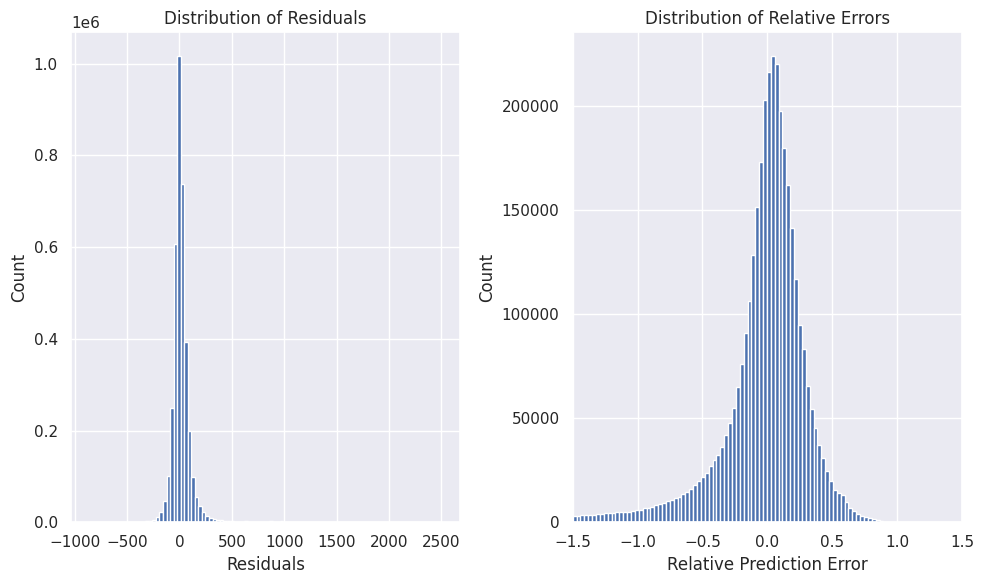

/tmp/ipykernel_370/2669580909.py:105: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('Diversion_Niccolo.png', dpi=300, bbox_inches='tight', format='png')
/opt/conda/envs/python3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


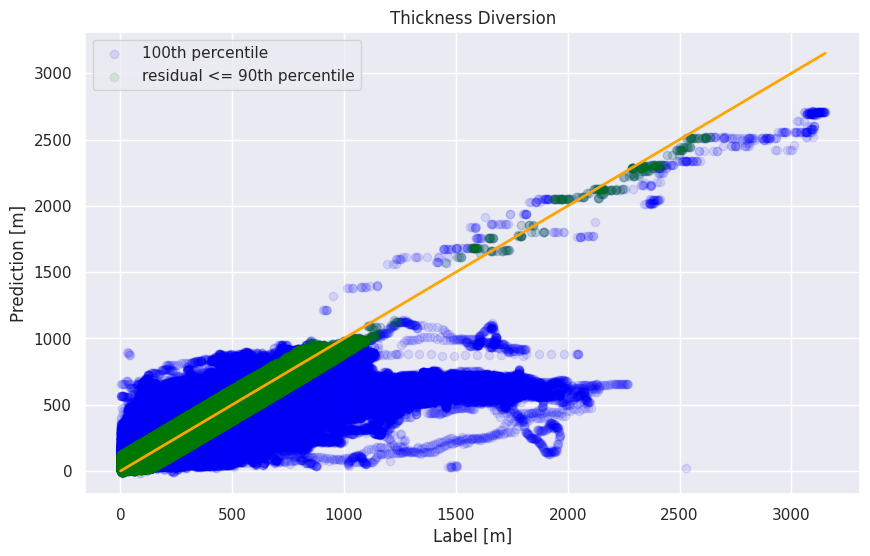

AttributeError: 'LGBMRegressor' object has no attribute 'evals_result'

In [16]:
evaluation_plot(model, data_regional['THICKNESS'], y_pred_regional)